In [ ]:
import sys ; sys.path.append('../../')
import torchdyn; from torchdyn.models import *; from torchdyn.datasets import *
import torch ; import torch.utils.data as data
import pytorch_lightning as pl
from src import *

import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

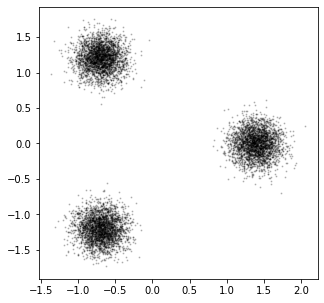

In [2]:
dataset = ToyDataset()
n_samples = 1 << 14
n_gaussians = 6 

def target_sample(n_samples):
    X, _ = dataset.generate(n_samples // n_gaussians, 'gaussians', n_gaussians=3, std_gaussians=0.5, radius=4, dim=2)
    X = (X - X.mean())/X.std()
    return X

x = target_sample(n_samples)

plt.figure(figsize=(5, 5))
plt.scatter(x[:,0], x[:,1], c='black', alpha=0.2, s=1.)

## CNF

In [3]:
hdim = 128
f = nn.Sequential(
        nn.Linear(2, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Softplus(),
        nn.Linear(hdim, hdim),
        nn.Tanh(),
        nn.Linear(hdim, 2))

cnf = CNF(f, trace_estimator=autograd_trace)
nde = NeuralDE(cnf, solver='dopri5', s_span=torch.linspace(1, 0, 2), sensitivity='adjoint', atol=1e-8, rtol=1e-8)
model = nn.Sequential(Augmenter(augment_idx=1, augment_dims=1), nde).to(device)

In [4]:
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform, Categorical
prior = MultivariateNormal(torch.zeros(2).to(device), torch.eye(2).to(device))

## Learner

In [5]:
# dummy trainloader
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1).to(device), torch.Tensor(1).to(device)), batch_size=1024, shuffle=True) 

# learner
class Learner(pl.LightningModule):
    def __init__(self, model:nn.Module):
        super().__init__()
        self.model = model
        self.iters = 0
        
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        self.iters += 1
        xT = target_sample(1024).to(device)
        x0_trJ = self.model(xT)  
        logprob = prior.log_prob(x0_trJ[:,1:]).to(xT) - x0_trJ[:,0]
        reg_loss = 0.01*torch.norm(self.model[1].defunc.m.net(x0_trJ[:,1:]), p=2, dim=1).mean()
        loss = -torch.mean(logprob)
        nde.nfe = 0
        if not self.iters%100:
            plot(model=self.model, target=xT, prior=prior, step=self.iters)
            self.model = self.model.to(device)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=1e-3, weight_decay=1e-6)

    def train_dataloader(self):
        return trainloader

A warning: the training process can take 1 hour or more depending on hardware. Following tutorials will show how to speed up CNF training through stochastic trace estimators and / or integral regularization terms.

In [ ]:
learn = Learner(model)
trainer = pl.Trainer(max_epochs=3000, gradient_clip_val=0.5)
trainer.fit(learn);

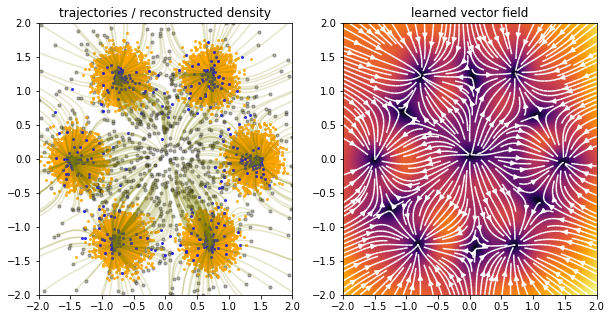

In [9]:
plot(model=model, target=x, prior=prior, step=0, show=True)
model = model.to(device)

In [10]:
torch.save(model.state_dict(), 'pretrained_models/ffjord_gaussians')